# OpenStreetMap 結合 Python，如何找到你想要的資料

### 常用的 Python 套件與方法
slide: 
<div style="text-align: right;">OpenStreetMap台灣 - 陳瑞霖</div>

# OpenStreetMap
* 地圖版的維基百科
* 在臺灣社群發展十年
* 自己的地圖自己畫
* tag 系統有彈性，能照顧少數需求
* 例：第三世界防災，原住民族語地圖

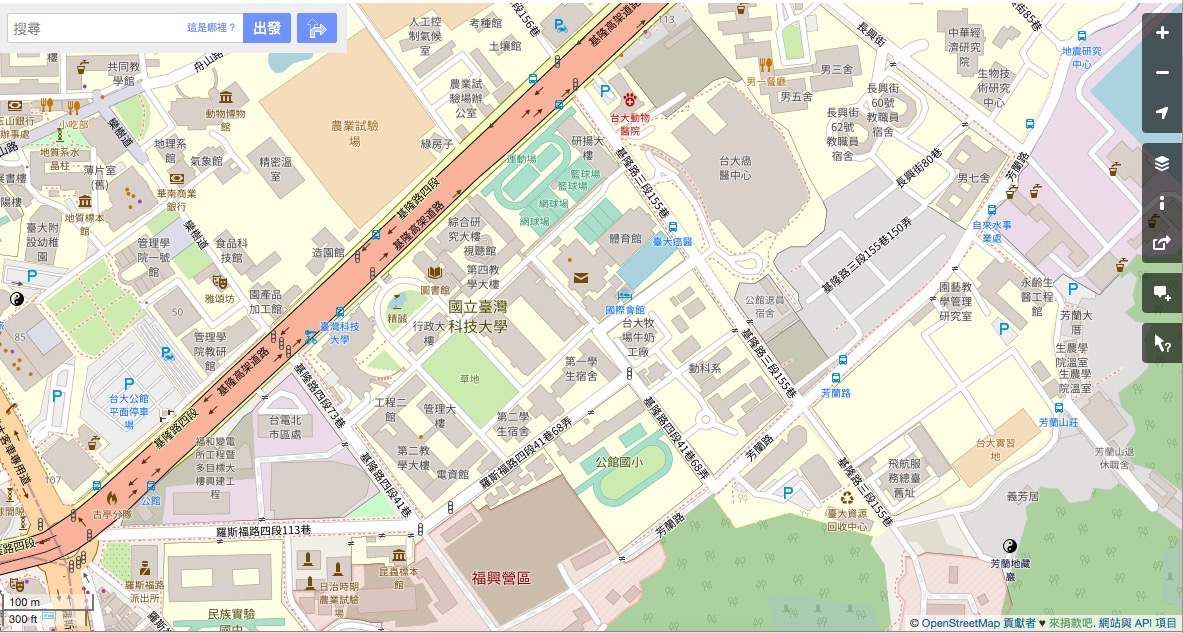

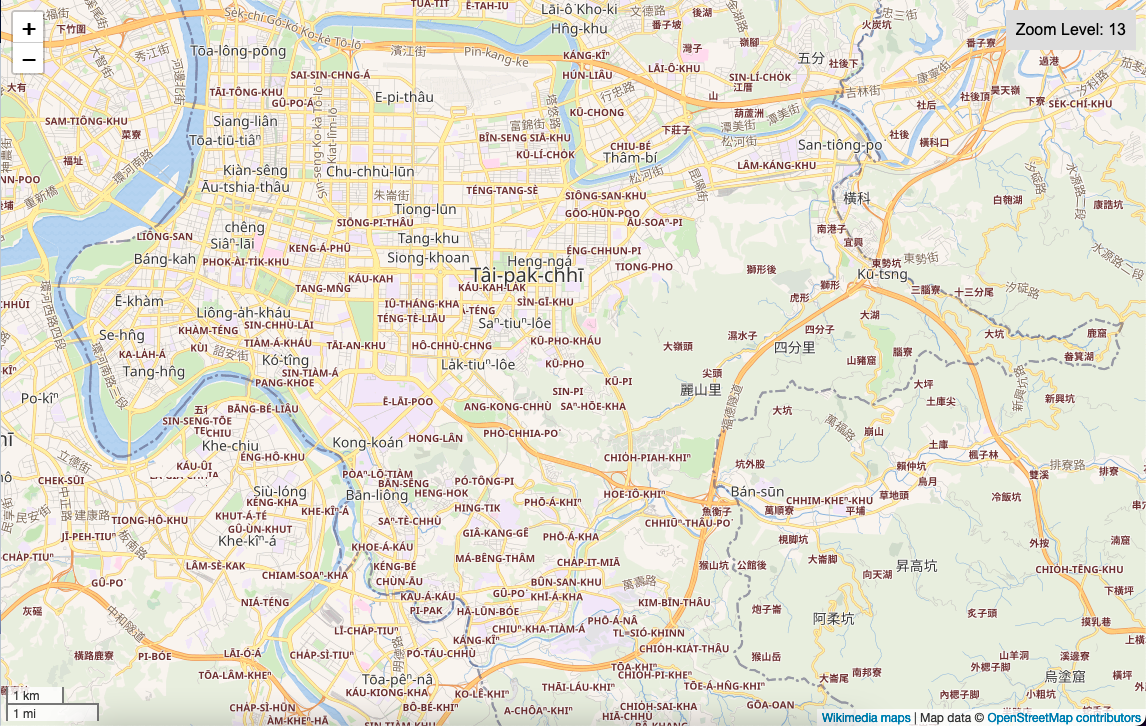
[Wikimedia Map: nan](https://maps.wikimedia.org/?lang=nan#13/25.0237/121.5717)

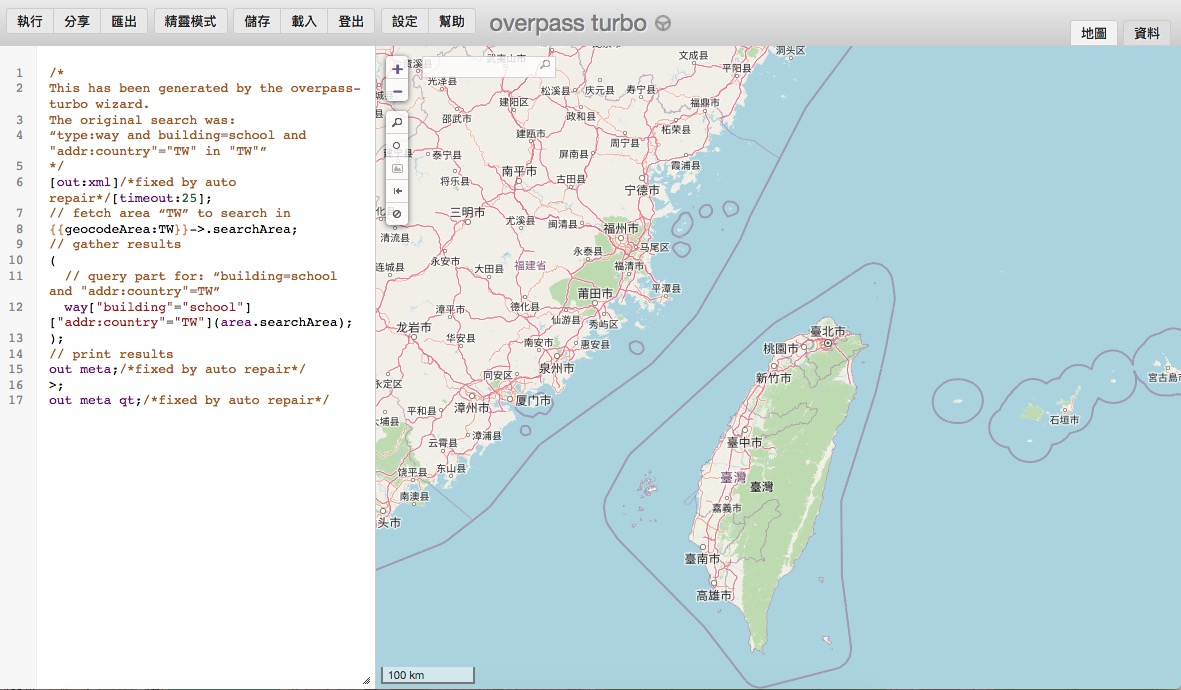

## 運用套件和資料
* 直接用常用的網路套件：requests、json
* Overpass API
* 專用基礎套件：OSMPythonTools、Geopy
* 進階套件：OSMnx
* 地圖呈現套件：folium

## requests、json
* 簡單，只要有架設網路相關套件就能取用 OpenStreetMap
* 難度，需要有基本的網頁知識與 API 概念

## OpenStreetMap 的 API
* OpenStreetMap API
* Overpass API
* 其他第三方 API，例如 Mapbox、Mapillary

In [ ]:
conda install -c conda-forge geopandas

In [1]:
import requests
import json


In [2]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["nat_ref"="63"][admin_level=4];
(node["amenity"="restaurant"](area);
 way["amenity"="restaurant"](area);
 rel["amenity"="restaurant"](area);
);
out center;
"""

In [3]:
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()

In [4]:
import numpy as np
import matplotlib.pyplot as plt # 輸出圖表用

# Collect coords into list
coords = []
for element in data['elements']:
  if element['type'] == 'node':
    lon = element['lon']
    lat = element['lat']
    coords.append((lon, lat))
  elif 'center' in element:
    lon = element['center']['lon']
    lat = element['center']['lat']
    coords.append((lon, lat))

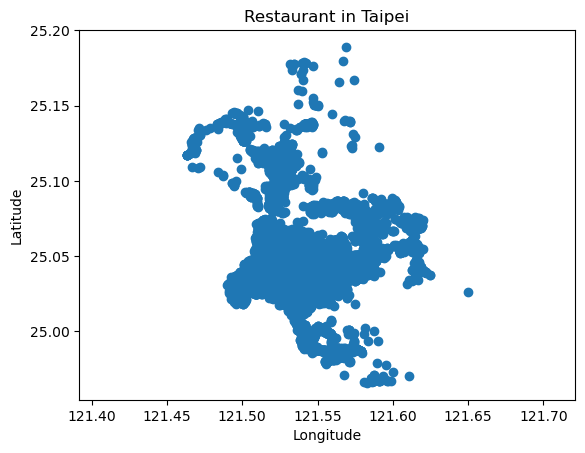

In [5]:
# Convert coordinates into numpy array
X = np.array(coords)

plt.plot(X[:, 0], X[:, 1], 'o')
plt.title('Restaurant in Taipei')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

Overpass Turbo 範例：臺北市的餐廳
https://overpass-turbo.eu/s/WDS

匯出存檔為 geojson 檔案，直接取得 GeoPandas 能處理的格式

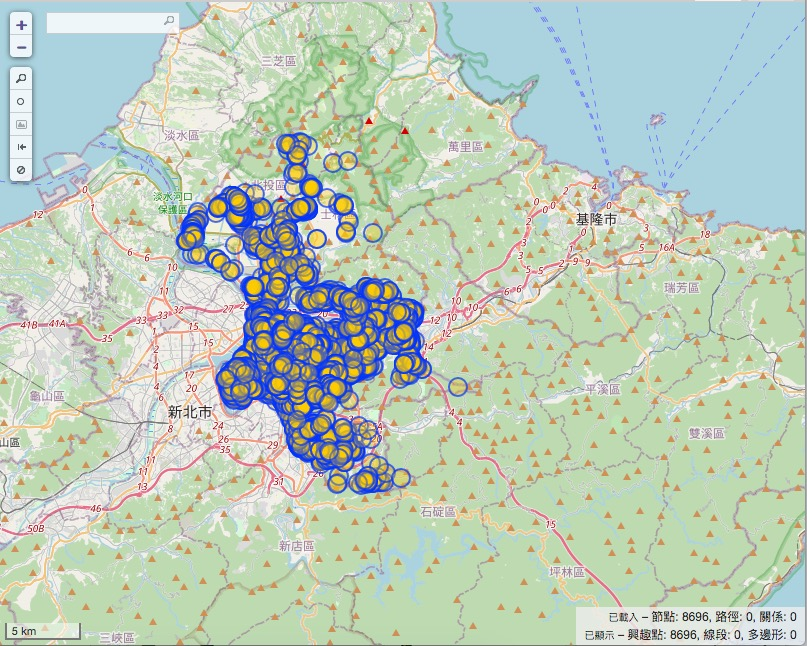

In [ ]:
conda install geopandas --force-reinstall

In [6]:
import geopandas as gpd
gdf = gpd.read_file("restaurant-tpe.geojson")
gdf.head()

id             @id access addr:city addr:country addr:district  \
0  node/283374379  node/283374379    NaN       台北市           TW           士林區   
1  node/299002404  node/299002404    NaN       NaN          NaN           NaN   
2  node/469812996  node/469812996    NaN       臺北市           TW           中正區   
3  node/569950080  node/569950080    NaN       NaN          NaN           NaN   
4  node/569950081  node/569950081    NaN       NaN          NaN           NaN   

  addr:floor                addr:full addr:full:en addr:hamlet  ...  \
0        NaN                      NaN          NaN         NaN  ...   
1        NaN                      NaN          NaN         NaN  ...   
2          2  10045臺北市中正區重慶南路一段129號2樓          NaN         NaN  ...   
3        NaN                      NaN          NaN         NaN  ...   
4        NaN                      NaN          NaN         NaN  ...   

  wheelchair:description wifi wikidata wikipedia                @timestamp  \
0                    NaN  NaN      NaN       NaN 2021-08-29 09:18:28+00:00   
1                    NaN  NaN      NaN       NaN 2013-08-04 17:26:22+00:00   
2                    NaN  NaN      NaN       NaN 2022-05-17 06:58:37+00:00   
3                    NaN  NaN      NaN       NaN 2009-11-24 11:06:59+00:00   
4                    NaN  NaN      NaN       NaN 2020-07-08 18:10:11+00:00   

  @version @changeset        @user     @uid                    geometry  
0        7  110404483     Supaplex   274857  POINT (121.52437 25.10649)  
1        6   17217722  Shangkuanlc   975241  POINT (121.56870 25.03218)  
2        9  121082514          林阿凱  7535457  POINT (121.51330 25.04201)  
3        1    3202851      TTaipei   200988  POINT (121.56903 25.02583)  
4        5   87717104   cmi3j89d9o   151425  POINT (121.56918 25.02465)  

[5 rows x 313 columns]

In [7]:
# Select some useful cols and print
cols = ['name', 'name:en', 'cuisine', 'addr:street', 'addr:housenumber', 'takeaway', 'delivery']
# Print only selected cols
gdf[cols].head(10)

name                     name:en      cuisine  \
0                温德德式烘焙餐館  Wendel's bakery and bistro       german   
1         N.Y.Bagels Cafe                         NaN     american   
2        TASTY西堤牛排 台北重慶南店                       TASTY  steak_house   
3                 various                         NaN          NaN   
4                   上品早餐坊                         NaN    breakfast   
5             Schwarzwald                         NaN       german   
6                   布納咖啡館                  BUNA CAF'E  coffee_shop   
7  3 Idiots toast & curry                         NaN        pizza   
8                    希臘佐巴                    Greek Go          NaN   
9                     樂雅樂                  Royal Host          NaN   

    addr:street addr:housenumber takeaway delivery  
0          德行西路                5      NaN      NaN  
1           NaN              NaN      NaN      NaN  
2        重慶南路一段              129      NaN       no  
3           NaN              NaN      NaN      NaN  
4           NaN              NaN      NaN      NaN  
5           NaN              NaN      NaN      NaN  
6         信義路四段            415之3      NaN      NaN  
7    羅斯福路三段283巷               28      NaN      NaN  
8  羅斯福路三段283巷7弄               16      NaN      NaN  
9           NaN              NaN      NaN      NaN

In [ ]:
 conda install -c conda-forge geopy

In [8]:
import geopy

from geopy.geocoders import Nominatim

geolocator = Nominatim(timeout=10, user_agent="sinica-intern")

# location = geolocator.geocode('1號, 市府路, 信義區, 臺北市, TW')

#test Chinese address
location = geolocator.geocode('臺北市信義區市府路1號')

location
# 無法跑出來
# https://practicaldatascience.co.uk/data-science/how-to-geocode-and-map-addresses-in-geopy

In [9]:
geolocator = Nominatim(timeout=10, user_agent="sinica-intern")

location = geolocator.geocode('1號, 市府路, 信義區, 臺北市, TW')

location

Location(1號, 市府路, 西村里, 信義區, 興雅, 臺北市, 110, 臺灣, (25.0374511, 121.5638672, 0.0))

In [10]:
geolocator = Nominatim(timeout=10, user_agent="sinica-intern")

location_sinica = geolocator.geocode('128號, 研究院路二段, 南港區, 臺北市, TW')

print((location_sinica.latitude, location_sinica.longitude))
# https://geopy.readthedocs.io/en/stable/#nominatim

(25.0420109, 121.6166903)


## 臺灣各地地址開放資料

* 臺中市
* 臺北市
* 臺東縣
* 苗栗縣
* 臺南市
* 高雄市
* 新竹市
* 桃園市

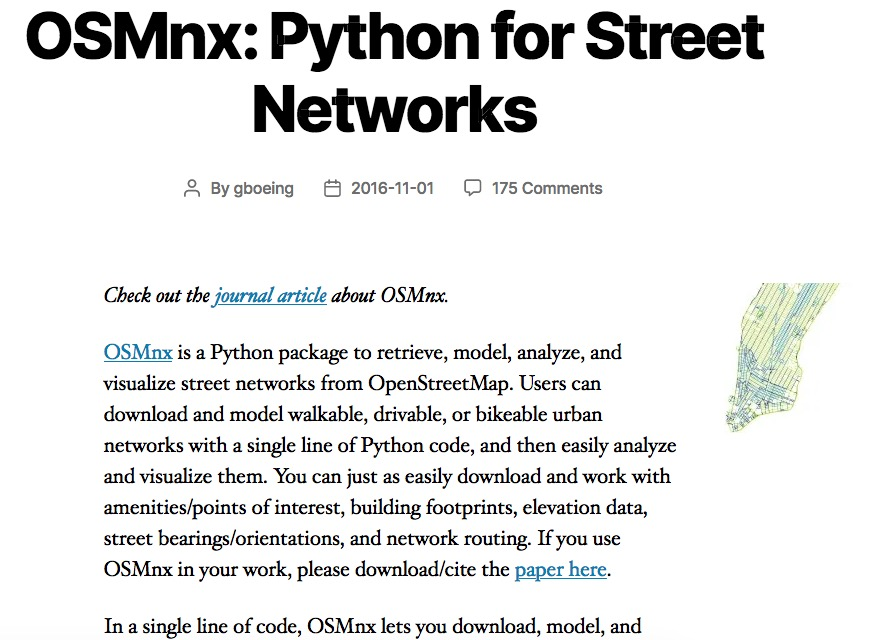

In [11]:
import osmnx as ox
import matplotlib.pyplot as plt 
%matplotlib inline

# ox.config(log_console=True, use_cache=True)
# ox.__version__

ox.settings.log_console=True
ox.config(log_console=True, use_cache=True)

/var/folders/z2/gh6dmn4s5gj0fbxjbbdgqk400000gn/T/ipykernel_96797/379788639.py:5: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(log_console=True, use_cache=True)


'1.5.1'

In [13]:
place = "Nangang District, Taipei City, Taiwan"
G = ox.graph_from_place(place)

In [20]:
ox.stats.basic_stats(G, clean_int_tol=False)
# 傳回基本的統計資訊

{'n': 30,
 'm': 66,
 'k_avg': 4.4,
 'edge_length_total': 2646.6219999999994,
 'edge_length_avg': 40.100333333333325,
 'streets_per_node_avg': 2.8,
 'streets_per_node_counts': {0: 0, 1: 5, 2: 0, 3: 21, 4: 4},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.16666666666666666,
  2: 0.0,
  3: 0.7,
  4: 0.13333333333333333},
 'intersection_count': 25,
 'street_length_total': 1323.311,
 'street_segment_count': 33,
 'street_length_avg': 40.10033333333333,
 'circuity_avg': 1.007379128307604,
 'self_loop_proportion': 0.0}

## osmnx
* 強項為路網分析
* networkx 衍生的套件

## Work Directly with planet data

* [The Whole Planet File](https://planet.openstreetmap.org/)
* [XML](https://planet.openstreetmap.org/planet/planet-latest.osm.bz2): 128GB
* [PPB](https://planet.openstreetmap.org/pbf/planet-latest.osm.pbf): 70GB

## Country specific planet data

* [Geofabrik](http://geofabrik.de/data/download.html)：分國家
* [BBbike](https://download.bbbike.org/osm/)：各大城市、客製化輸出範圍

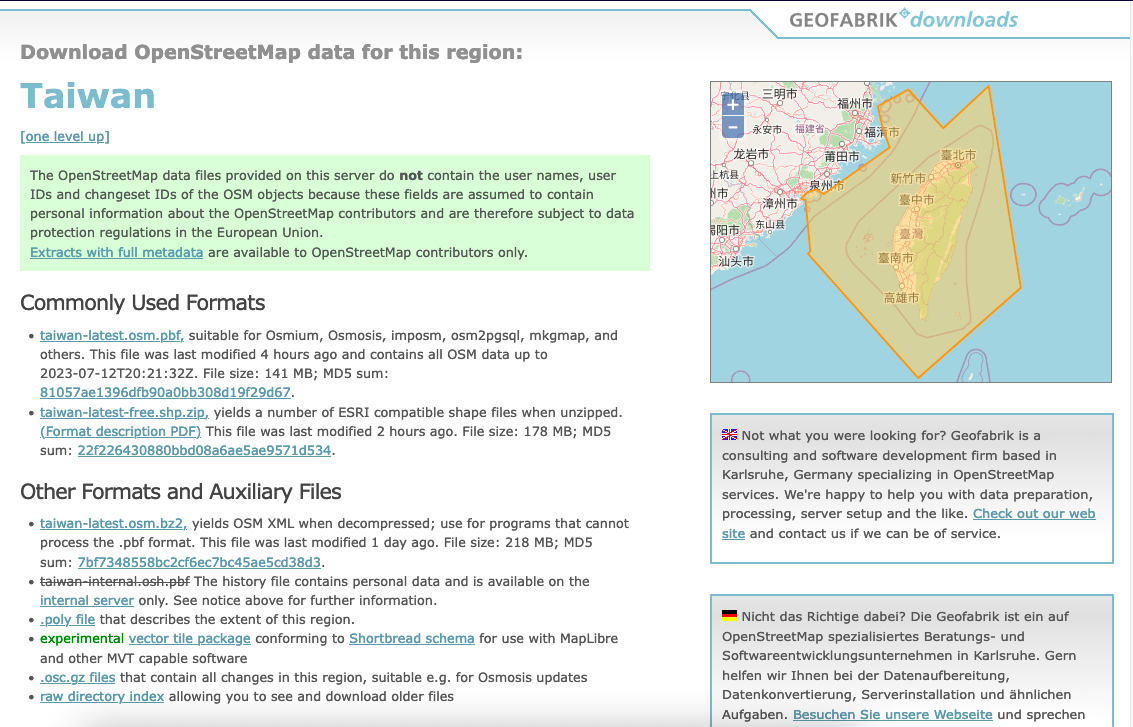

## ommand line tool: osmium

* [osmium](https://osmcode.org/osmium-tool/index.html)
* 有 command line、Python Package

Object `osmium` not found.


## osmium

命行列輸入下一行查看台灣資料狀況：

    osmium fileinfo taiwan-latest.osm.pbf



輸入下一行查看進階資訊：

    osmium fileinfo -e taiwan-latest.osm.pbf




列出台灣村里關係用到的標籤組合
    
    osmium tags-filter taiwan-latest.osm.pbf r/boundary=administrative | osmium tags-filter r/admin_level=9 -o village.osm.pbf
    
    osmium tags-filter -f pbf taiwan-latest.osm.pbf - r/boundary=administrative | osmium 'tags-filter' -F=pbf -R -o village.osm.pbf  - 'r/admin_level=9'

    osmium tags-count village.osm.pbf


    osmium tags-filter taiwan-latest.osm.pbf r/type=waterway -o Taiwan-river.osm.pbf

    osmium tags-count -t relation Taiwan-river.osm.pbf type=waterway



    osmium tags-filter -f pbf taiwan-latest.osm.pbf shop=convenience | osmium tags-count -F pbf - 'name=*'


# Wikidata 上的 OpenStreetMap 資料
* 幫忙打 Wikidata 廣告
* 介紹 Wikidata Query Service
* 也可以用 Python 來截取資料


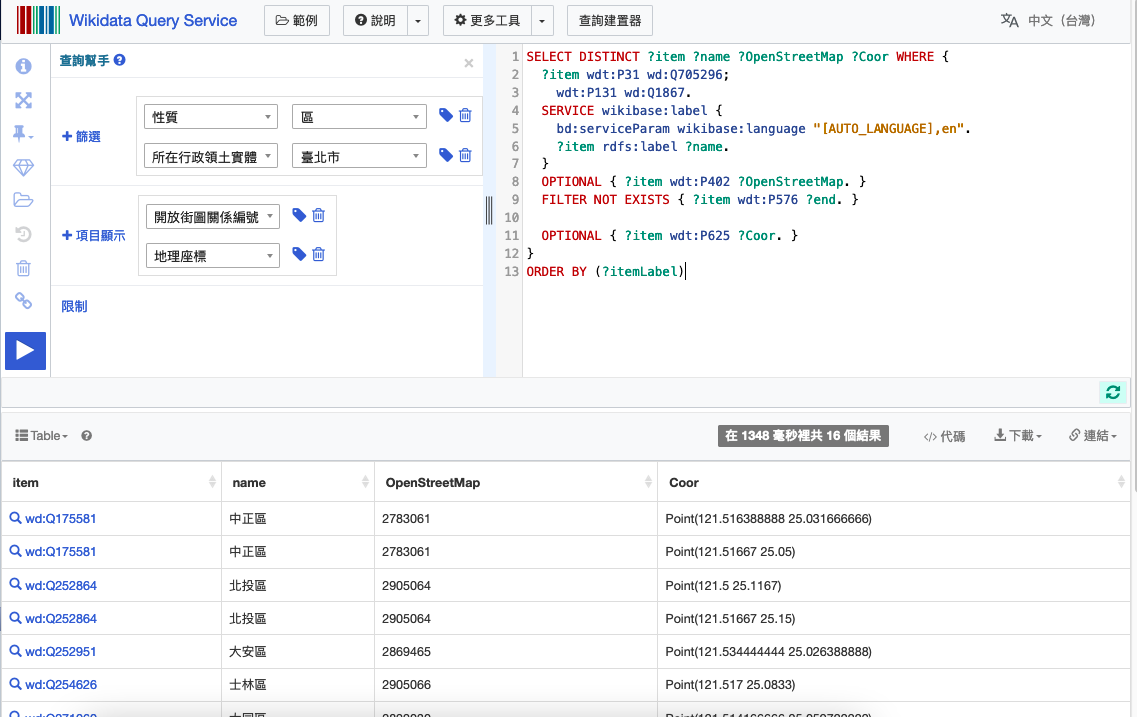
https://w.wiki/72SH

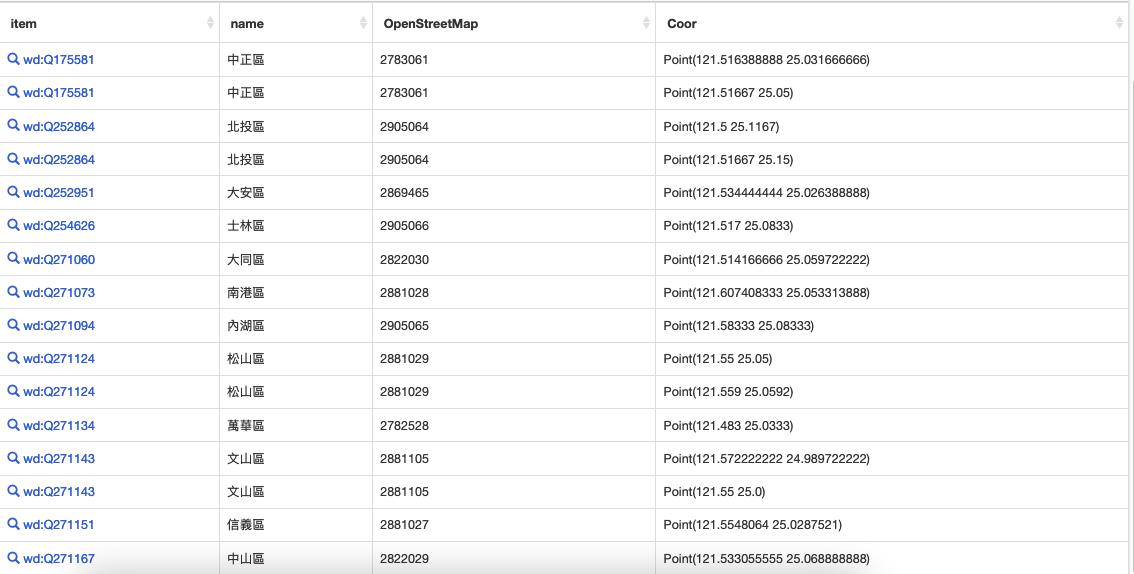

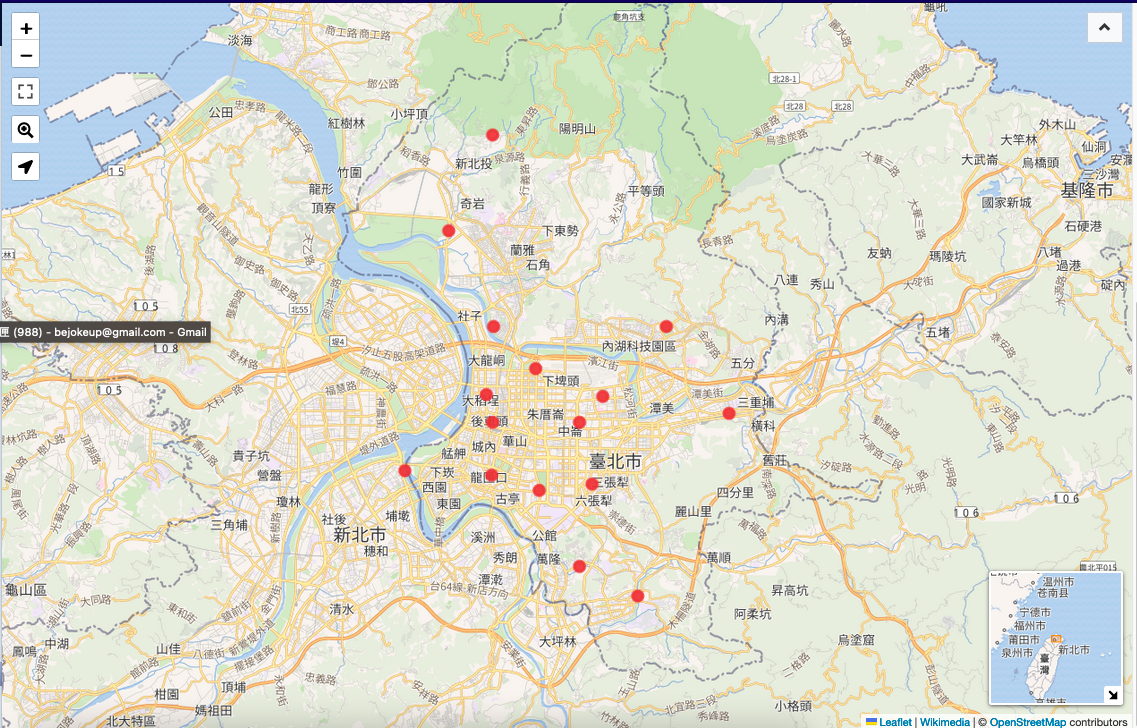

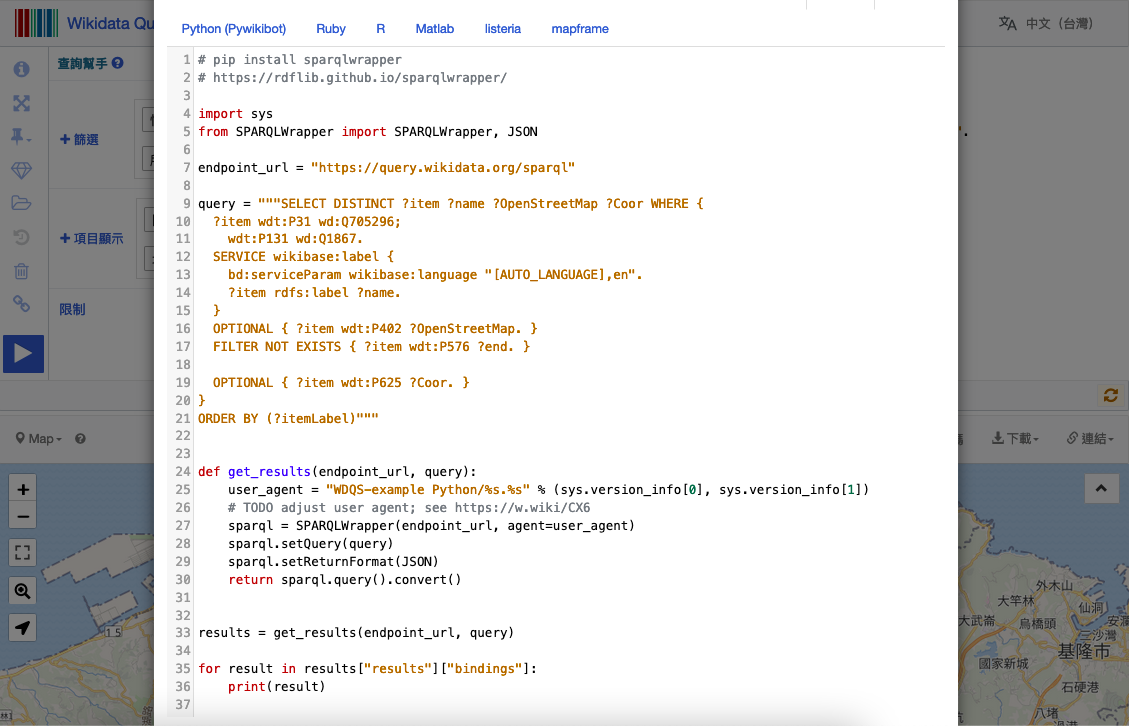

In [ ]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT DISTINCT ?item ?name ?Hu ?OpenStreetMap ?Coor WHERE {
  ?item wdt:P31 wd:Q705296;
    wdt:P131 wd:Q1867.
  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],zh".
    ?item rdfs:label ?name.
  }
  FILTER NOT EXISTS { ?item wdt:P576 ?end. }  
  OPTIONAL { ?item wdt:P5020 ?Hu. }
  OPTIONAL { ?item wdt:P402 ?OpenStreetMap. }

}
ORDER BY (?itemLabel)"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    print(result)


Python 的地圖套件：
* IPython.display
* Folium

In [ ]:
%matplotlib inline
import ogr
import shapely
from shapely.geometry import *
import geopandas as gpd
import matplotlib.pyplot as plt
import IPython.display as display

osm = """
<iframe width="500" height="400" frameborder="0" scrolling="no" marginheight="0" marginwidth="0" \
src="http://www.openstreetmap.org/export/embed.html?bbox=121.5391%2C25.0175%2C121.5489%2C25.0106&amp;layer=mapnik" \
style="border: 1px solid black"></iframe><br/><small><a \
href="http://www.openstreetmap.org/#map=17/25.01392/121.54314">View Larger Map</a></small>
"""
display.HTML(osm)


In [ ]:
import folium

m = folium.Map(location=[25.04297, 121.55711], zoom_start = 17)
m

In [ ]:
folium.Marker(location=[25.04297, 121.55711], popup="PyData",tooltip="Click").add_to(m)
m

In [ ]:
folium.Marker(location=[25.04297, 121.55711], popup="Youreator",tooltip="Click").add_to(m)
m

In [ ]:
m.save('index.html')

# 謝謝大家

QA

下次 OpenStreetMap x Wikidata 月聚：2023 8/15

# 參考資料

Reveal.js
* [Reveal.js](https://revealjs.com/)

Overpass API
* https://towardsdatascience.com/loading-data-from-openstreetmap-with-python-and-the-overpass-api-513882a27fd0

OSMnx:
* [OSMnx Example](https://github.com/gboeing/osmnx-examples/blob/master/notebooks)：[路網分析](https://github.com/gboeing/osmnx-examples/blob/master/notebooks/06-example-osmnx-networkx.ipynb)
* [赫爾辛基大學 Geo-Python-AutoGIS 課程-Retrieving OpenStreetMap data](https://automating-gis-processes.github.io/2017/lessons/L7/retrieve-osm-data.html)
* [OSMnx 說明文件](https://osmnx.readthedocs.io/en/stable/osmnx.html)
* [Day20 OSMnx應用 ](https://ithelp.ithome.com.tw/articles/10207981?sc=iThelpR)

IPython:
* http://darribas.org/gds15/content/labs/lab_03.html
* https://automating-gis-processes.github.io/site/notebooks/L5/interactive-map-folium.html

Folium:
* https://www.youtube.com/watch?v=QpBmO35pmVE
* https://github.com/tsaisunghao/Geography/blob/master/EarthquakeMap/geomapping.ipynb
* https://github.com/victorgau/wzu20180122/blob/master/%E5%9C%B0%E5%9C%96%E7%AF%84%E4%BE%8B/%E7%94%A8%20folium%20%E7%95%AB%E5%9C%B0%E5%9C%96.ipynb
* https://github.com/gotoariel/folium-demo/blob/master/demo/demo.ipynb